# The following notebooks shows the pixels of one image in different color-spaces and clusters them with the k-means method in order to get color-schemes of the images. It has to be mentioned that the k-means method is not the best method, since it is not 100% deterministic. However the visualisation of the clusters is quite convincing. But their might be minor differences in the color scheme when the random state would be changed.

In [34]:
%matplotlib notebook

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.misc import imread
import matplotlib.cbook as cbook
from sklearn import neighbors
from sklearn import neighbors
import imageio
from mpl_toolkits.mplot3d import Axes3D
import colorsys
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin
from sklearn.datasets import load_sample_image
from sklearn.utils import shuffle
from skimage.color import rgb2lab, lab2rgb
from time import time
from scipy.spatial import distance_matrix
from scipy.spatial.distance import cdist
from scipy.optimize import linear_sum_assignment
import math

def show_colors(color_list):
    out_img = np.zeros((10,10,3))
    out_img[:,:] = color_list[0]
    for i in range (color_list.shape[0]-1):
        out_conc = np.zeros((10,10,3))
        out_conc[:,:] = color_list[i+1]
        out_img = np.concatenate((out_img,out_conc),axis=0)
    return out_img

def rgb_list_to_hsv(inp_list):
    hsv_list = np.zeros((inp_list.shape[0],3))
    for i in range (inp_list.shape[0]):
        hsv_list[i] = colorsys.rgb_to_hsv(inp_list[i,0],inp_list[i,1],inp_list[i,2])
    return hsv_list

def hsv_list_to_rgb(inp_list):
    rgb_list = np.zeros((inp_list.shape[0],3))
    for i in range (inp_list.shape[0]):
        rgb_list[i] = colorsys.hsv_to_rgb(inp_list[i,0],inp_list[i,1],inp_list[i,2])
    return rgb_list



# Load and display the image

<IPython.core.display.Javascript object>


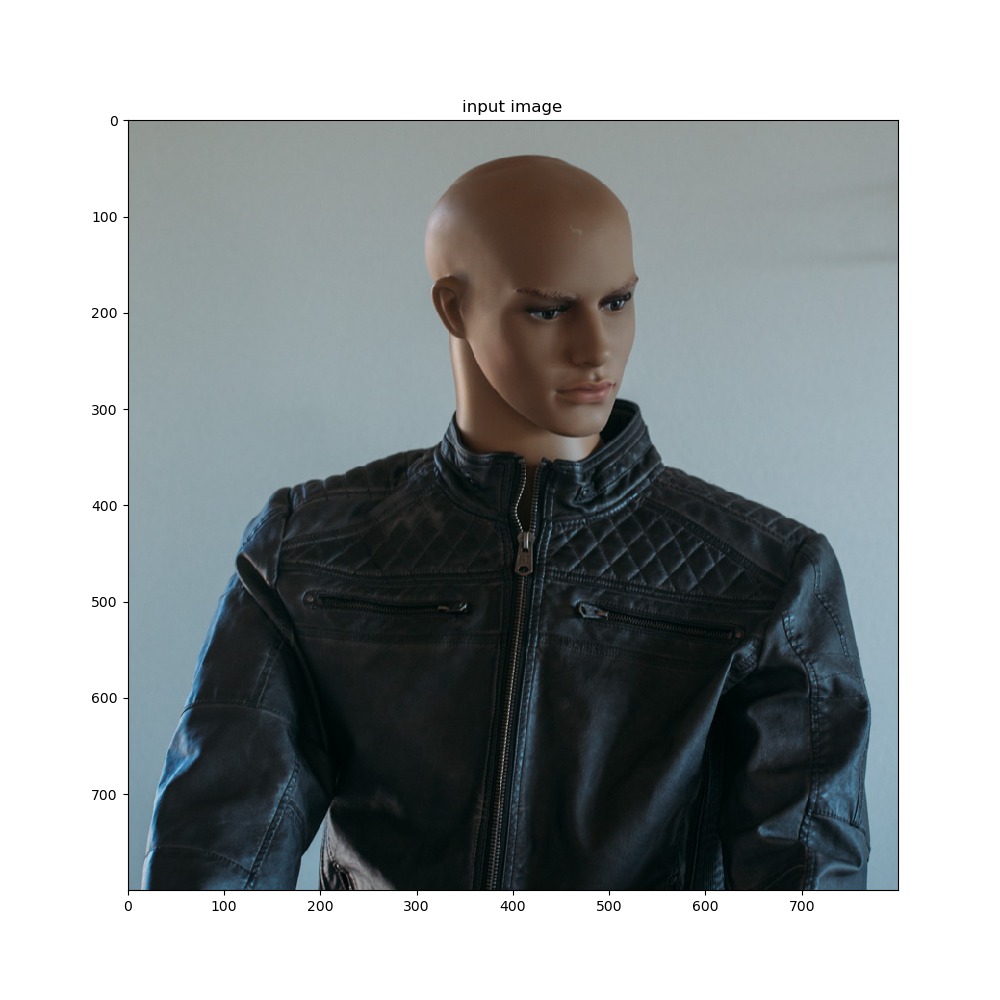

In [3]:
img_inp = imageio.imread('input.jpg')/255

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ax.set_title('input image')
ax.imshow(img_inp)
plt.show()

# Show a subsample of the pixels in a cartesian coordinate system. Their coordinates are the r g b values

<IPython.core.display.Javascript object>


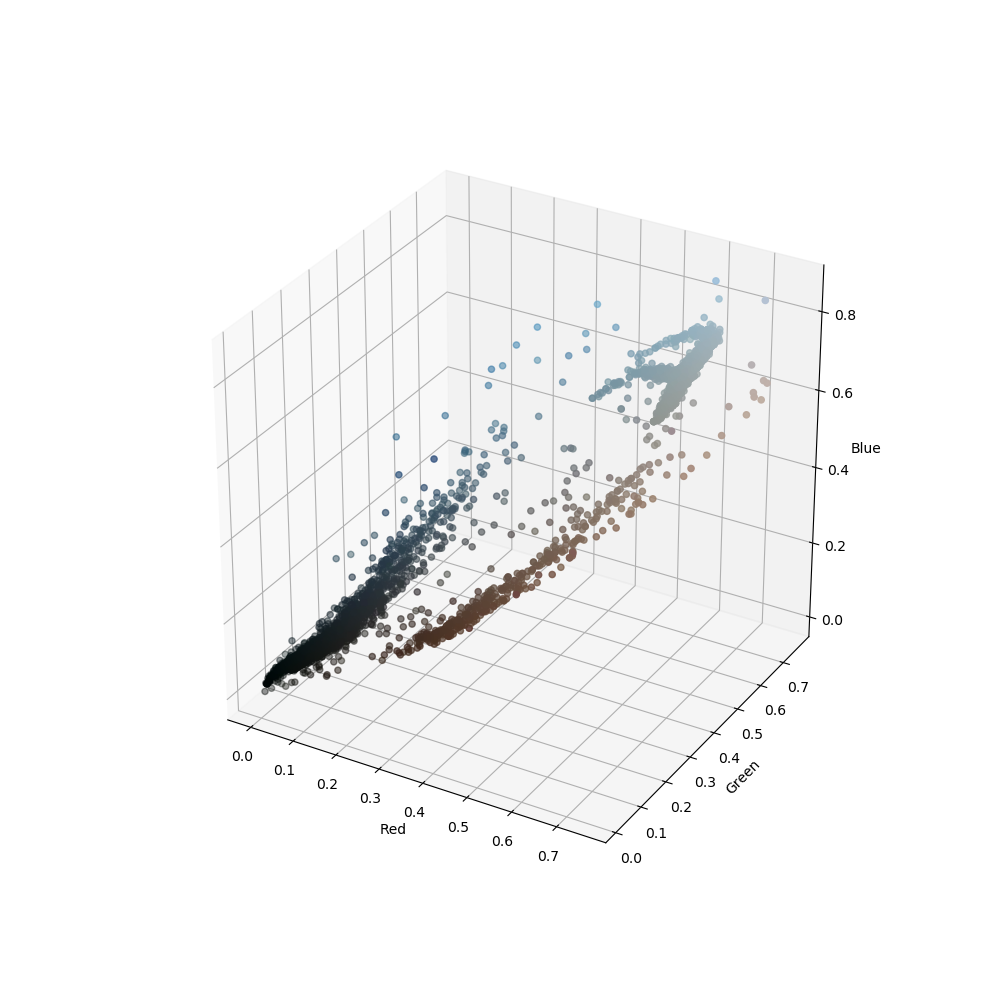

In [36]:
pixel_list = np.reshape(img_inp,(img_inp.shape[0]*img_inp.shape[1],3))
pixel_list = shuffle(pixel_list, random_state=0)[:5000]
fig = plt.figure(figsize=[10,10])
ax = fig.add_subplot(111, projection = '3d')

ax.scatter(pixel_list[:,0],pixel_list[:,1], pixel_list[:,2], c=pixel_list)

plt.show()

ax.set_xlabel('Red')
ax.set_ylabel('Green')
ax.set_zlabel('Blue')
plt.show()


# Cluster the rgb values. As it can be seen, it basically clusters them along the main diagonal between (0,0,0) and (1,1,1). Therefore the means of the clusters are near this axis, which is the "grey-axis", on which all values have no saturation. Consequently the color scheme has a low saturation.

<IPython.core.display.Javascript object>


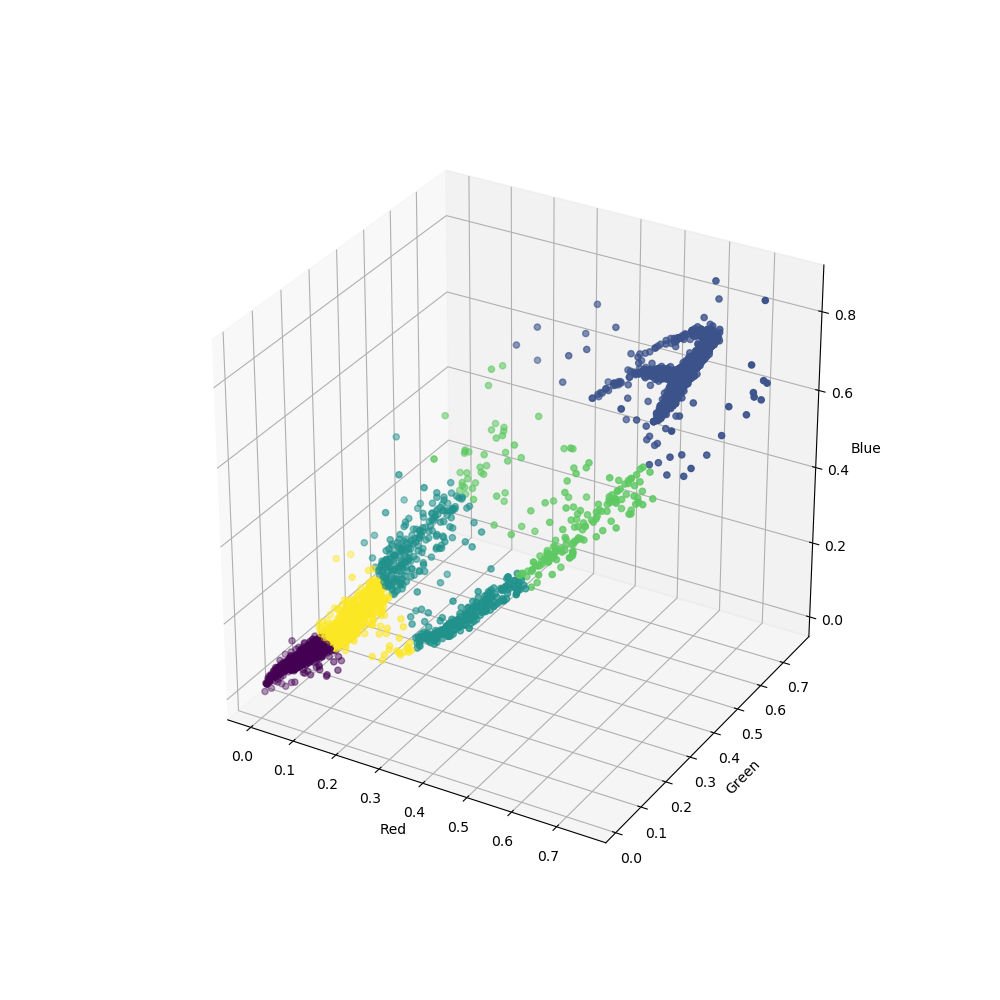

<IPython.core.display.Javascript object>


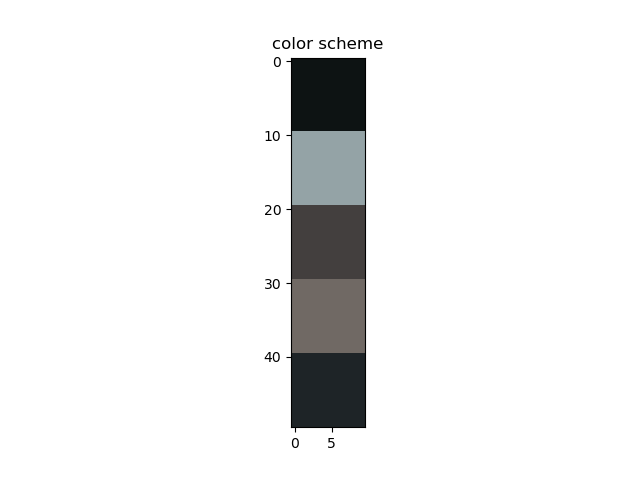

Text(0.5, 1.0, 'color scheme')

In [5]:
n_colors = 5
kmeans = KMeans(n_clusters=n_colors, random_state=0).fit(pixel_list)
labels = kmeans.predict(pixel_list)
colors = kmeans.cluster_centers_
LABEL_COLOR_MAP = {0 : 'r',
                   1 : 'g',
                   2 : 'b',
                   3 : 'c',
                   4 : 'k',
                   }
label_color = [LABEL_COLOR_MAP[l] for l in labels]

fig = plt.figure(figsize=[10,10])
ax = fig.add_subplot(111, projection = '3d')

ax.scatter(pixel_list[:,0],pixel_list[:,1], pixel_list[:,2], c=labels)

plt.show()

ax.set_xlabel('Red')
ax.set_ylabel('Green')
ax.set_zlabel('Blue')
plt.show()

color_scheme = show_colors(colors)

fig = plt.figure()
a = fig.add_subplot(1, 1, 1)
imgplot = plt.imshow(color_scheme)
a.set_title('color scheme')


# Converting the RGB Values in HSV values and showing them while there coordinates are there HSV values

<IPython.core.display.Javascript object>


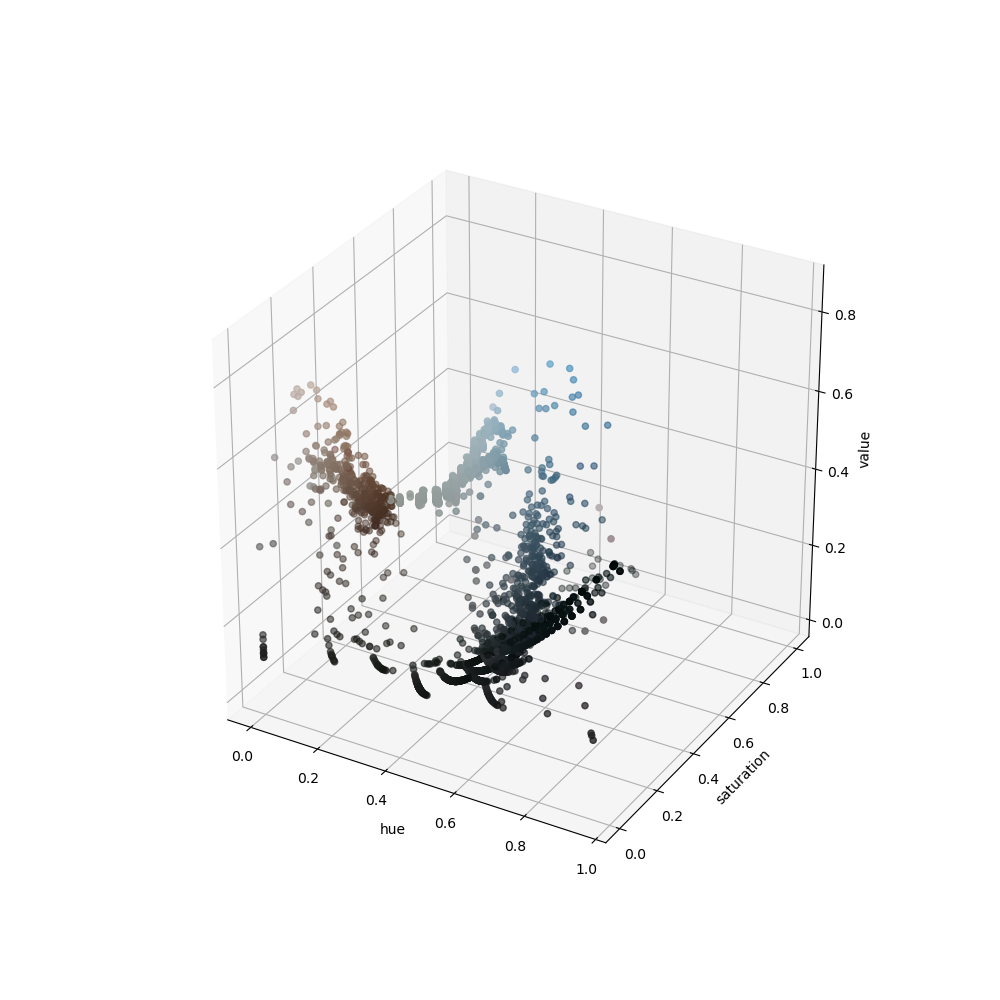

In [6]:

hsv_pixel_list = rgb_list_to_hsv(pixel_list)


fig = plt.figure(figsize=[10,10])
ax = fig.add_subplot(111, projection = '3d')

ax.scatter(hsv_pixel_list[:,0],hsv_pixel_list[:,1], hsv_pixel_list[:,2], c=pixel_list)

plt.show()

ax.set_xlabel('hue')
ax.set_ylabel('saturation')
ax.set_zlabel('value')
plt.show()


# It's not pssible to use the current k-means clustering algorithm in order to cluster hsv values since the hue values are along a circle. So the clustering algorithm would not take into consideration that for example the values 3° and 364° are only 9° appart from each other. Instead it would assume that there distance would be 361°. We have to take into consideration that the hsv values are cylindrical coordinates. So in order to show them in a cartesian coordinate system and in order to cluster them according to their cartesian distance, we need to convert them to cartesian coordinates

<IPython.core.display.Javascript object>


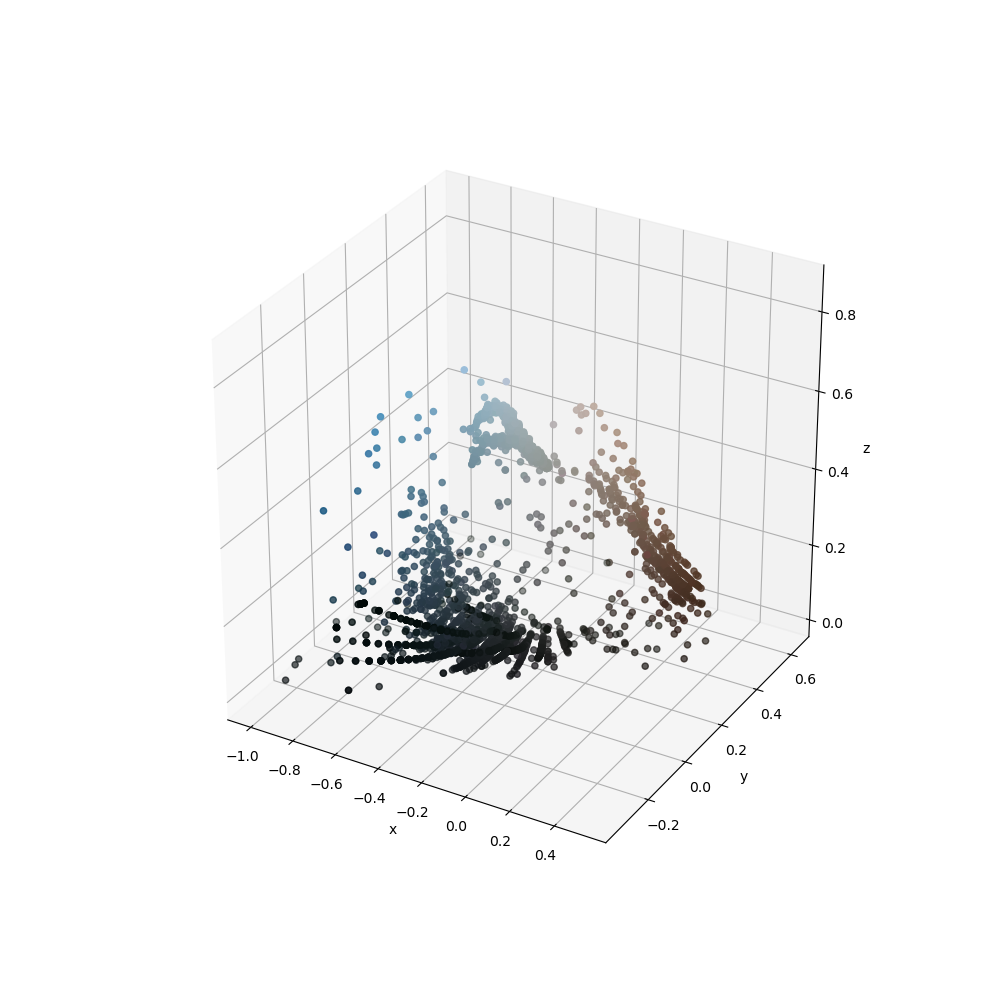

In [7]:
def cylindrical_to_cart(inp_list):
    cart_list = np.zeros((inp_list.shape[0],3))
    for i in range (inp_list.shape[0]):
        theta = inp_list[i,0]*2*math.pi
        radius = inp_list[i,1]
        height = inp_list[i,2]
        cart_list[i,0] = math.cos(theta)*radius
        cart_list[i,1] = math.sin(theta)*radius
        cart_list[i,2] = height
    return cart_list
cart_hsv_list = cylindrical_to_cart(hsv_pixel_list)

fig = plt.figure(figsize=[10,10])
ax = fig.add_subplot(111, projection = '3d')

ax.scatter(cart_hsv_list[:,0],cart_hsv_list[:,1], cart_hsv_list[:,2], c=pixel_list)

plt.show()

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()

        

# Here the hsv values get clustered in a cartesian coordinate system. In order to get the color scheme we need to convert the coordinates of the resulting color scheme back to cylindrical coordinates. As we can see the resulting color scheme is more saturated and actually closer to our perception

<IPython.core.display.Javascript object>


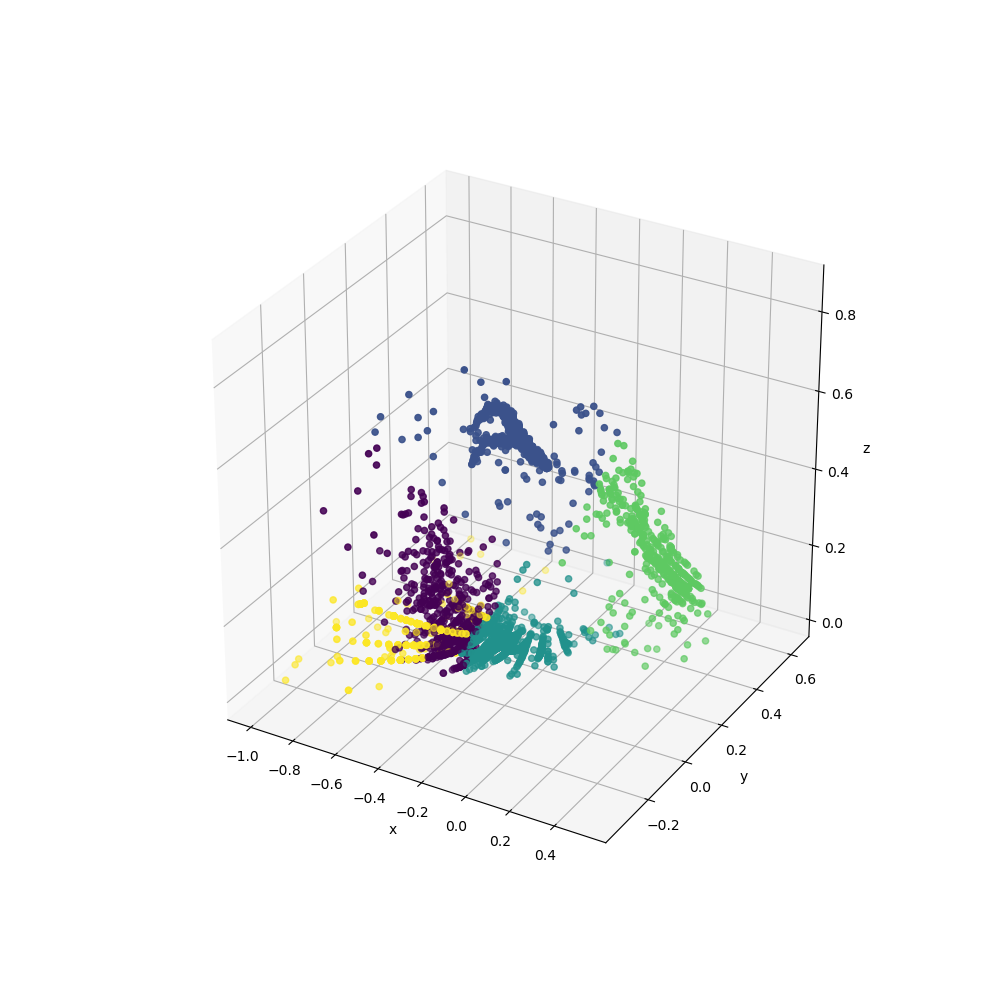

<IPython.core.display.Javascript object>


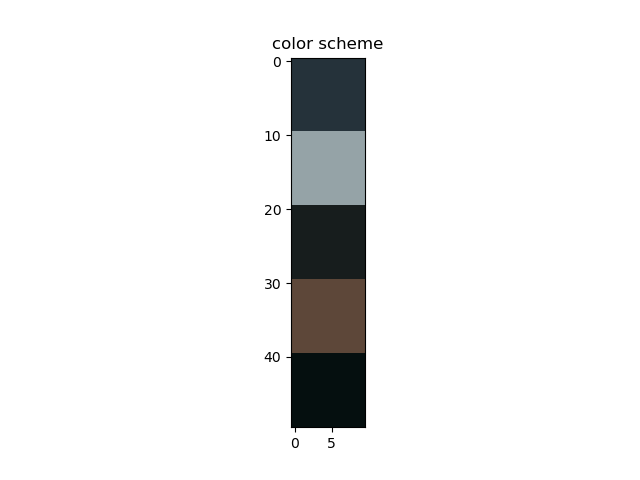

Text(0.5, 1.0, 'color scheme')

In [8]:
n_colors = 5
def cart_to_cylindrical(inp_list):
    cylindrical = np.zeros((inp_list.shape[0],3))
    for i in range (inp_list.shape[0]):
        x = inp_list[i,0]
        y = inp_list[i,1]
        z = inp_list[i,2]
        cylindrical[i,0] = (math.atan(y/x)+math.pi*(0.5-0.5*np.sign(x)))/(math.pi*2)
        cylindrical[i,1] = math.sqrt(x**2+y**2)         
        cylindrical[i,2] = z
    return cylindrical
        
kmeans_hsv = KMeans(n_clusters=n_colors, random_state=0).fit(cart_hsv_list)
hsv_labels = kmeans_hsv.predict(cart_hsv_list)
hsv_colors = kmeans_hsv.cluster_centers_
hsv_colors = cart_to_cylindrical(hsv_colors)

hsv_display_colors = hsv_list_to_rgb(hsv_colors)
LABEL_COLOR_MAP = {0 : 'r',
                   1 : 'g',
                   2 : 'b',
                   3 : 'c',
                   4 : 'k',
                   }
label_color = [LABEL_COLOR_MAP[l] for l in labels]

fig = plt.figure(figsize=[10,10])
ax = fig.add_subplot(111, projection = '3d')

ax.scatter(cart_hsv_list[:,0],cart_hsv_list[:,1], cart_hsv_list[:,2], c=hsv_labels)

plt.show()

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()

color_scheme = show_colors(hsv_display_colors)

fig = plt.figure()
a = fig.add_subplot(1, 1, 1)
imgplot = plt.imshow(color_scheme)
a.set_title('color scheme')

# Below we make a little variation: we take the clusters according to their cartesian coordinates from above. But we calculate the mean of each cluster in the corresponding cylindrical hsv coordinate system. As it can be seen the results are very similar. However there might be cases in which the difference is larger. For example if you have a red pixel and a cyan pixel with with only slightly less saturation in the same cluster, their cartesian mean would be a greyish red. The component-wise mean of the cylindrical coordinates would be a green with a saturation between the red and blue pixel.

<IPython.core.display.Javascript object>


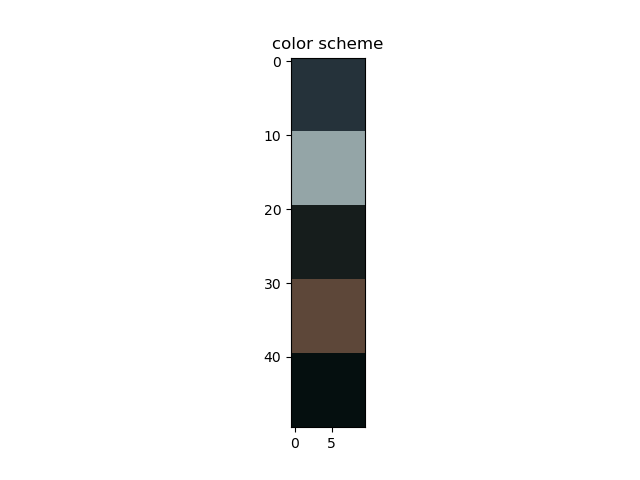

Text(0.5, 1.0, 'color scheme')

In [9]:

n_colors = 5
hsv_sums = np.zeros((n_colors,3))
hsv_means = np.zeros((hsv_labels.shape[0],3))
hue_shift = 0.5 - hsv_colors[:,0]
hsv_pixel_list_shifted = np.zeros(3)
for i in range (hsv_pixel_list.shape[0]):
    label = hsv_labels[i]
    hsv_pixel_list_shifted[:] = hsv_pixel_list[i,:] 
    hsv_pixel_list_shifted[0] = hsv_pixel_list[i,0] + hue_shift[label]
    hsv_sums[label,:] = hsv_sums[label,:] + hsv_pixel_list_shifted[:]
unique, element_count = np.unique(hsv_labels, return_counts=True) 

hsv_means = hsv_sums / element_count[:,None]
corrected_hue = hsv_means[:,0] - hue_shift
hsv_means[:,0] = corrected_hue
hsv_display_colors = hsv_list_to_rgb(hsv_means)

color_scheme = show_colors(hsv_display_colors)

fig = plt.figure()
a = fig.add_subplot(1, 1, 1)
imgplot = plt.imshow(color_scheme)
a.set_title('color scheme')


# Now we convert the RGB values into LAB values. The LAB color space is designed in a way that is close to the human perception. Since the brightness ("l") is on the height axis, the color components are on the x-y plane and the grey-axis is a vertical axis in the middle, it has the benefits of the HSV space. At the same time it uses cartesian coordinates and not HSV coordinates, which makes it more straight forward to use. 

<IPython.core.display.Javascript object>


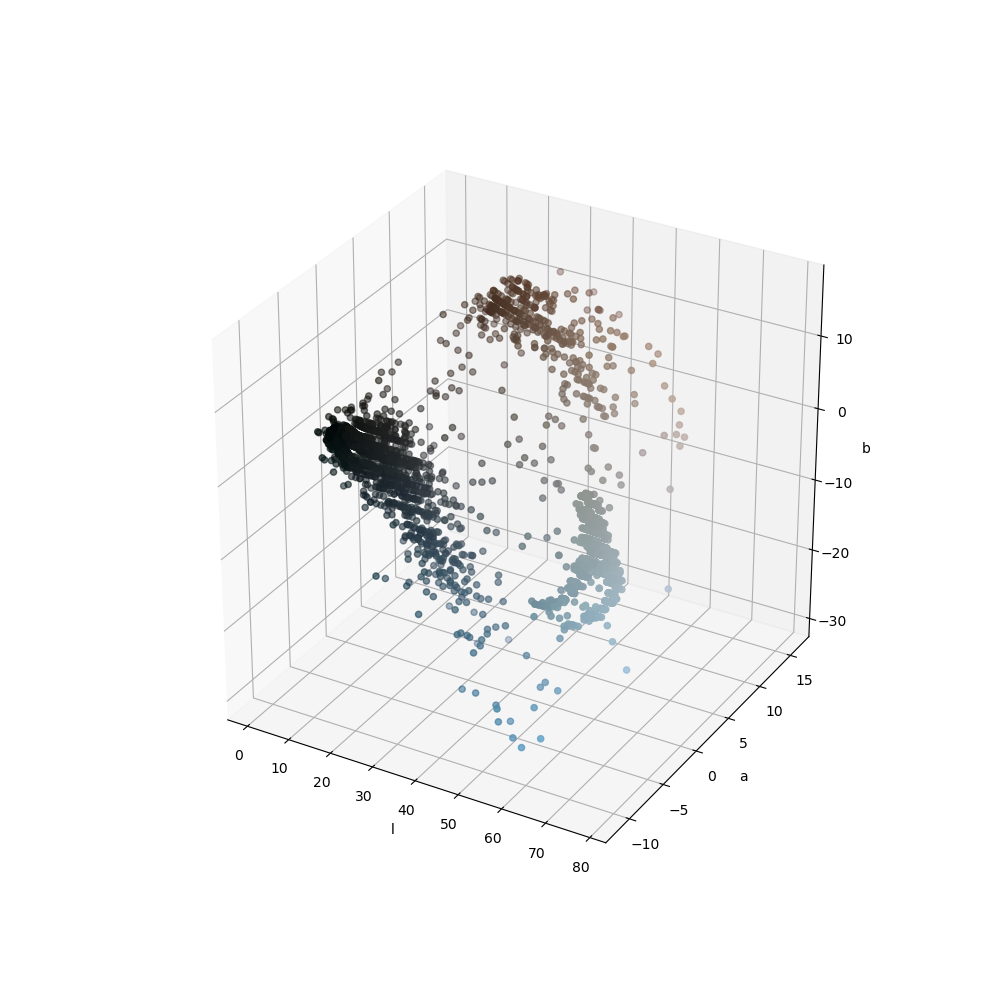

In [37]:
pixel_array = np.reshape(pixel_list,(pixel_list.shape[0],1,3))
lab_pixel_list = np.reshape(rgb2lab(pixel_array),(pixel_list.shape[0],3))
fig = plt.figure(figsize=[10,10])
ax = fig.add_subplot(111, projection = '3d')

ax.scatter(lab_pixel_list[:,0],lab_pixel_list[:,1], lab_pixel_list[:,2], c=pixel_list)

plt.show()

ax.set_xlabel('l')
ax.set_ylabel('a')
ax.set_zlabel('b')
plt.show()




# The clusters in the LAB space are visually convincing. In the example image used by this notebook it distinguishes more colors.

<IPython.core.display.Javascript object>


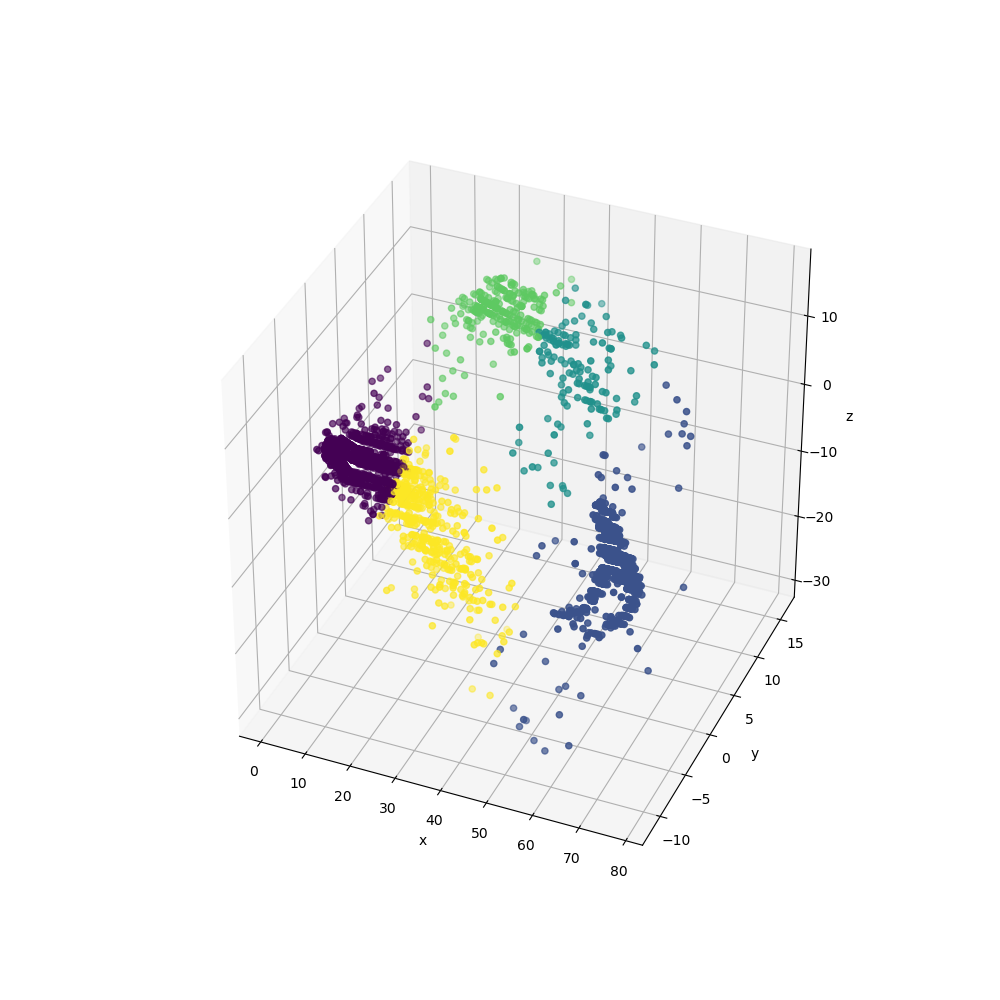

<IPython.core.display.Javascript object>


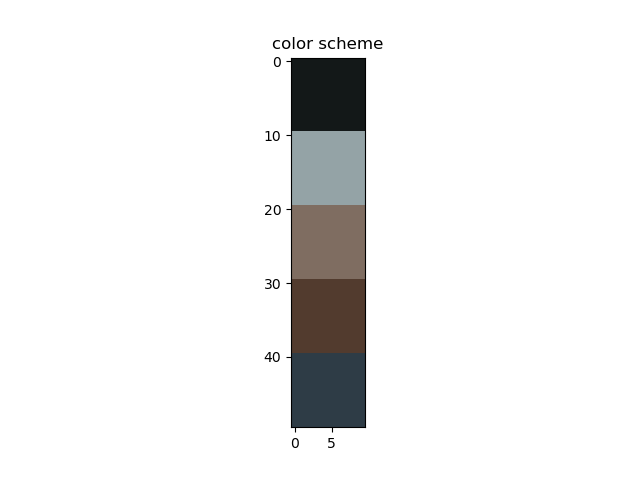

Text(0.5, 1.0, 'color scheme')

In [33]:
kmeans_lab = KMeans(n_clusters=n_colors, random_state=0).fit(lab_pixel_list)
lab_labels = kmeans_lab.predict(lab_pixel_list)
lab_colors = kmeans_lab.cluster_centers_

lab_display_colors = np.reshape(lab2rgb(np.reshape(lab_colors,(lab_colors.shape[0],1,3))),(lab_colors.shape[0],3))
color_scheme = show_colors(lab_display_colors)

label_color = [LABEL_COLOR_MAP[l] for l in labels]

fig = plt.figure(figsize=[10,10])
ax = fig.add_subplot(111, projection = '3d')

ax.scatter(lab_pixel_list[:,0],lab_pixel_list[:,1], lab_pixel_list[:,2], c=lab_labels)

plt.show()

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()

fig = plt.figure()
a = fig.add_subplot(1, 1, 1)
imgplot = plt.imshow(color_scheme)
a.set_title('color scheme')